In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_data = pd.read_csv("../input/titanic/test.csv")
train_data = pd.read_csv("../input/titanic/train.csv")

In [3]:
train_data["Survived"].sum()

342

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Explore missing values - looks like we"ll have to impute the age. Embarked only has two missing values so we can impute this also.

In [8]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Explore the features available out of the box and their impact on survival rate

In [10]:
train_data.groupby("Embarked").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


In [11]:
train_data.groupby("Sex").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


In [12]:
train_data.groupby("Pclass").mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [13]:
train_data.groupby("SibSp").mean()

,PassengerId,Survived,Pclass,Age,Parch,Fare
SibSp,,,,,,
0,455.370066,0.345395,2.351974,31.397558,0.185855,25.692028
1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


In [14]:
train_data.groupby("Parch").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


Add some additional features - 

First extract the title from the name - could be an indicator of social status, which may be relevant to survival rate. We already know that sex is a huge influencer - but the rarer titles may also influence the outcome

In [15]:
data = [train_data, test_data]

for dataset in data:
    dataset["Title"] = dataset["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
    dataset["Title"] = dataset["Title"].replace(["Lady", "Countess", "Capt", "Col", "Don", "Dr","Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")
    dataset["Title"] = dataset["Title"].fillna("Unknown")

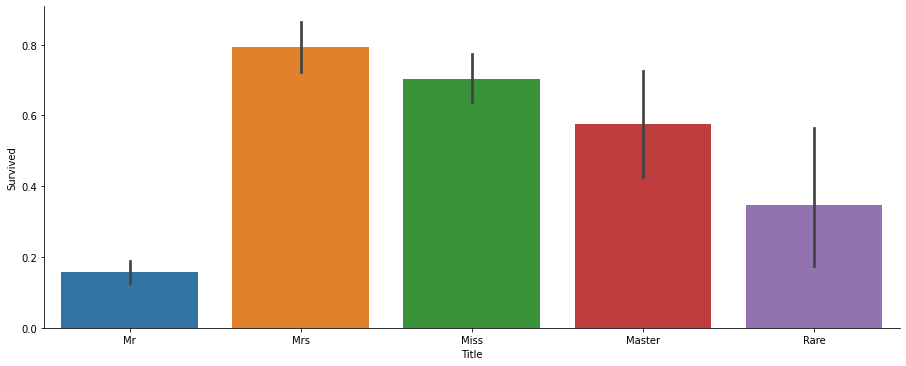

In [16]:
sns.catplot(data=train_data, x="Title", y="Survived", aspect=2.5, kind="bar")

Use the Parch & SibSp features to count the number of people travelling - also add a flag for travelling alone or not - as per below visualisations these appear to influence the surival rate

In [17]:
datasets = [train_data, test_data]

for dataset in datasets:
    dataset["Relatives"] = dataset["Parch"] + dataset["SibSp"]
    dataset.loc[dataset["Relatives"] == 0, "TravelledAlone"] = "Yes"
    dataset.loc[dataset["Relatives"] > 0, "TravelledAlone"] = "No"
    
train_data.groupby("TravelledAlone").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Relatives
TravelledAlone,,,,,,,,
No,427.79661,0.505650,2.169492,26.413452,1.316384,0.960452,48.832275,2.276836
Yes,458.00000,0.303538,2.400372,32.220297,0.000000,0.000000,21.242689,0.000000


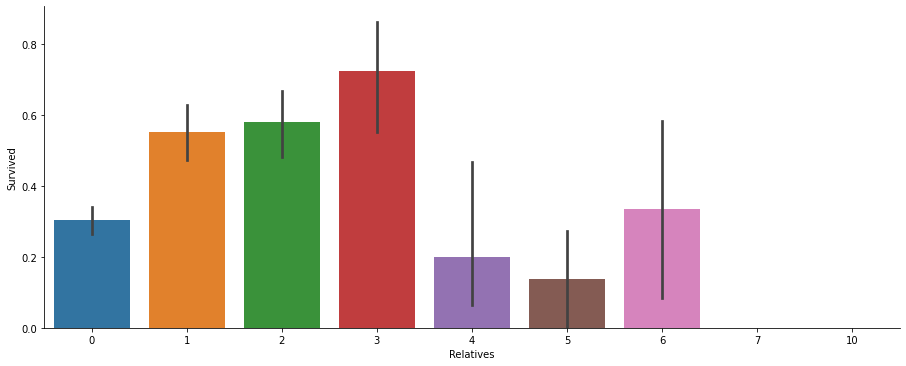

In [18]:
sns.catplot(data=train_data, x="Relatives", y="Survived", aspect=2.5, kind="bar")

Travelling alone, if you were male, had a negative impact on your chances of survival - women however survived more often when travelling alone!

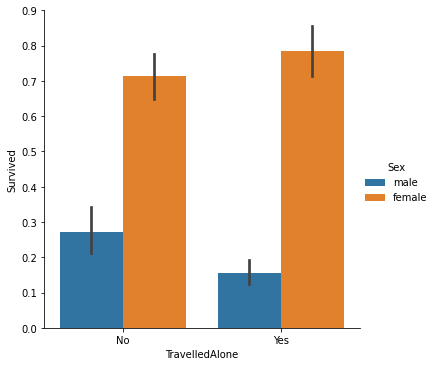

In [19]:
sns.catplot(data=train_data, x="TravelledAlone", y="Survived", kind="bar", hue="Sex")

Strip out the first character from the Cabin feature - this appears to be the deck - could be relevant

In [20]:
train_data["Deck"] = train_data["Cabin"].str.slice(stop=1)
test_data["Deck"] = train_data["Cabin"].str.slice(stop=1)

In [21]:
train_data["Deck"].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64

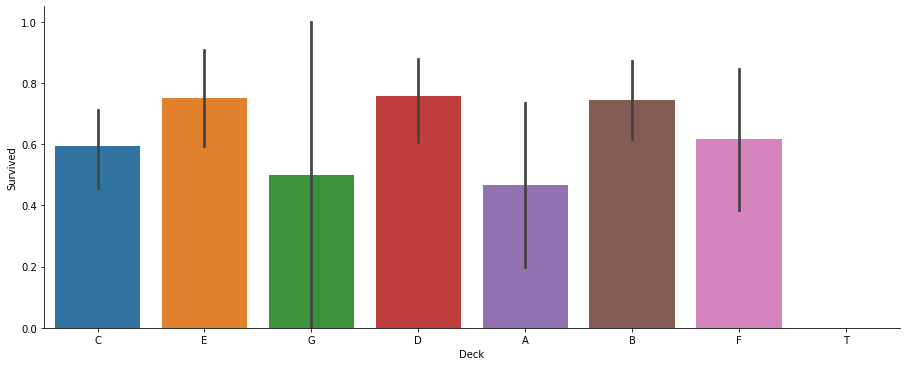

In [22]:
sns.catplot(data=train_data, x="Deck", y="Survived", kind="bar", aspect=2.5)

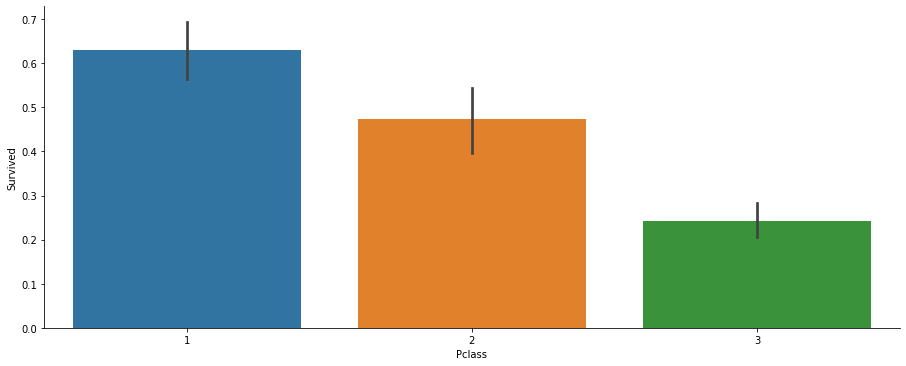

In [23]:
sns.catplot(data=train_data, x="Pclass", y="Survived", kind="bar", aspect=2.5)

Dropping the original features that we have already engineered.

In [24]:
train_data.drop(["Name", "Ticket", "SibSp", "Parch", "Cabin"], axis=1, inplace=True)
test_data.drop(["Name", "Ticket", "SibSp", "Parch", "Cabin"], axis=1, inplace=True)

In [25]:
train_data.isna().sum()

PassengerId         0
Survived            0
Pclass              0
Sex                 0
Age               177
Fare                0
Embarked            2
Title               0
Relatives           0
TravelledAlone      0
Deck              687
dtype: int64

Define a pipeline (probably not needed - this is just for my own practice)

In [26]:
y = train_data["Survived"]
train_data.drop("Survived", axis=1, inplace=True)

In [27]:
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ["float64", "int64"]]
categorical_cols = [cname for cname in train_data.columns if train_data[cname].dtype == "object"]

numerical_transformer = SimpleImputer(strategy="mean")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

In [28]:
def score_model(train, target, n_estimators, max_depth):
    my_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    my_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", my_model)
    ])

    cv_scores = cross_val_score(my_pipeline, train, target, cv=2, scoring="accuracy")
    
    return cv_scores

In [29]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

scores = {str(i): score_model(train_data, y, i, 5).mean() for i in n_estimators}


In [30]:
scores

{'50': 0.7755857308409331,
 '100': 0.7699803496750138,
 '150': 0.7789439209956165,
 '200': 0.7867939739003376,
 '250': 0.7879125308610873,
 '300': 0.7856703783947196,
 '350': 0.7879125308610873,
 '400': 0.7879125308610873,
 '450': 0.7856703783947196,
 '500': 0.7856703783947196}

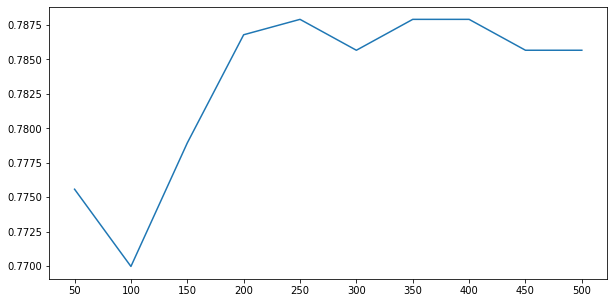

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(list(scores.keys()), list(scores.values()))
plt.show()

In [32]:
my_final_model = RandomForestClassifier(n_estimators=250, max_depth=5, random_state=0)

my_final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", my_final_model)
])

In [33]:
my_final_pipeline.fit(train_data, y)
preds = my_final_pipeline.predict(test_data)

In [34]:
output = pd.DataFrame({"PassengerId": test_data.PassengerId, "Survived": preds})
output.to_csv("my_submission.csv", index=False)